# Introduction to $\chi2$ Fitting 

In experimental High Energy Physics (HEP), we frequently need to extract meaningful parameters from measured data distributions. The **chi-squared (χ²) fitting method** is one of the most fundamental and widely used statistical techniques for this purpose.

### What is Chi² Fitting?

Chi² fitting is a method to find the best-fit parameters of a theoretical model to experimental data by minimizing the chi-squared statistic:

$$\chi^2 = \sum_{i=1}^{N} \frac{(y_i - f(x_i; \theta))^2}{\sigma_i^2}$$

Where:
- $y_i$ = observed data point
- $f(x_i; \theta)$ = theoretical model with parameters $\theta$
- $\sigma_i$ = uncertainty (error) on data point $i$
- $N$ = number of data points

# Perform the fit with `curve_fit`

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Step 1: Generate Simulated Data


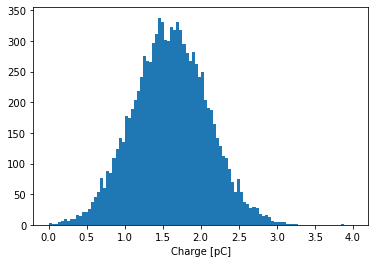

In [ ]:
# Generate simulated experimental data
# Parameters chosen to mimic PMT single photoelectron response
mean_charge = 1.6  # Mean charge in picocoulombs [pC]
resolution = 0.3   # Relative resolution (30%)
n_events = 10000   # Number of simulated events

# Generate random samples from normal distribution
s = np.random.normal(loc=mean_charge, scale=mean_charge*resolution, size=n_events)

# Create histogram from the generated data
ydata, xbin, p = plt.hist(s, bins=100, range=(0,4), alpha=0.7, label='Simulated Data')
plt.xlabel('Charge [pC]')
plt.ylabel('Number of Events')
plt.title('Simulated PMT Single Photoelectron Response')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate bin centers for fitting (x-coordinates of histogram bins)
xdata = (xbin[1:] + xbin[:-1]) * 0.5

print(f"Generated {n_events} events")
print(f"True parameters: μ = {mean_charge} pC, σ = {mean_charge*resolution:.2f} pC")
print(f"Histogram has {len(xdata)} bins")

## Step 3: Define the Theoretical Model

### The Gaussian Function

The normalized Gaussian (normal) distribution is:

$$f(x) = \frac{A}{\sigma\sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

For fitting histograms, we often use the unnormalized form:

$$f(x) = A \cdot e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

Where:
- **A**: Amplitude (related to total number of events)
- **μ**: Mean (central value of the distribution)
- **σ**: Standard deviation (width of the distribution)


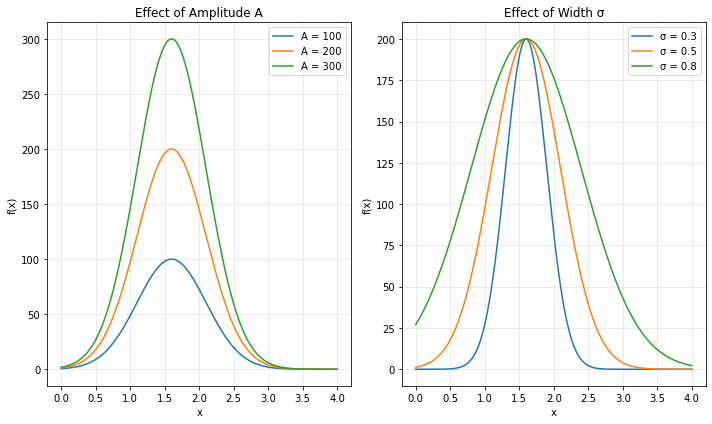

In [11]:
# Define the Gaussian function for fitting
def gaus(x, A, mu, sigma):
    """
    Gaussian function for curve fitting
    
    Parameters:
    x : array-like, independent variable (e.g., charge, energy, time)
    A : float, amplitude parameter
    mu : float, mean parameter  
    sigma : float, standard deviation parameter
    
    Returns:
    array-like, Gaussian function values
    """
    arg = (x - mu) / sigma  # Standardized variable
    return A * np.exp(-0.5 * arg * arg)  # Unnormalized Gaussian

# Let's visualize what this function looks like with different parameters
x_demo = np.linspace(0, 4, 1000)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
# Effect of amplitude A
for A in [100, 200, 300]:
    y_demo = gaus(x_demo, A, 1.6, 0.5)
    plt.plot(x_demo, y_demo, label=f'A = {A}')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Effect of Amplitude A')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Effect of standard deviation sigma
for sigma in [0.3, 0.5, 0.8]:
    y_demo = gaus(x_demo, 200, 1.6, sigma)
    plt.plot(x_demo, y_demo, label=f'σ = {sigma}')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Effect of Width σ')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4: Perform the Chi² Fit

### Why Restrict the Fitting Range?

In experimental HEP, we often need to be careful about which data to include in our fits:

1. **Low Statistics**: Bins with very few events have large uncertainties and can dominate the χ² calculation inappropriately
2. **Systematic Effects**: Detector edge effects or background contamination may be present at the extremes
3. **Model Validity**: Our theoretical model may only be valid in a certain range

### Statistical Considerations

For histogram fitting, we assume **Poisson statistics** for each bin:
- The uncertainty in each bin is $\sigma_i = \sqrt{N_i}$ where $N_i$ is the number of events in bin $i$
- This approximation is valid when $N_i \gtrsim 10$
- For bins with few events, other statistical treatments may be more appropriate


In [12]:
# Define fitting range to avoid low-statistics bins
xmin = 0.5  # Lower bound for fitting range
xmax = 2.5  # Upper bound for fitting range

# Create mask to select data within fitting range
mask = (xdata > xmin) & (xdata < xmax)
xdata_fit = xdata[mask]  # X-coordinates for fitting
ydata_fit = ydata[mask]  # Y-coordinates (bin contents) for fitting

# Calculate uncertainties assuming Poisson statistics
sigma_fit = np.sqrt(ydata_fit)

# Handle bins with zero entries (avoid division by zero)
sigma_fit[sigma_fit == 0] = 1  # Set minimum uncertainty for empty bins

print(f"Fitting range: {xmin} to {xmax} pC")
print(f"Number of bins in fit: {len(xdata_fit)}")
print(f"Total events in fitting range: {np.sum(ydata_fit):.0f}")

# Perform the chi-squared fit using scipy.optimize.curve_fit
popt, pcov = curve_fit(gaus, xdata_fit, ydata_fit, sigma=sigma_fit)

print('\n=== FIT RESULTS ===')
print('Best fit parameters:')
print(f'  A (amplitude) = {popt[0]:.2f}')
print(f'  μ (mean) = {popt[1]:.4f} pC')
print(f'  σ (standard deviation) = {popt[2]:.4f} pC')

print('\nCovariance Matrix:')
print(pcov)

# Compare with true values
print('\n=== COMPARISON WITH TRUE VALUES ===')
print(f'True μ = {mean_charge:.4f} pC, Fitted μ = {popt[1]:.4f} pC')
print(f'True σ = {mean_charge*resolution:.4f} pC, Fitted σ = {popt[2]:.4f} pC')

Fitting range: 0.5 to 2.5 pC
Number of bins in fit: 49
Total events in fitting range: 9495

=== FIT RESULTS ===
Best fit parameters:
  A (amplitude) = 326.03
  μ (mean) = 1.5950 pC
  σ (standard deviation) = 0.4864 pC

Covariance Matrix:
[[ 1.38964426e+01 -1.20815673e-03 -1.11278623e-02]
 [-1.20815673e-03  2.41542948e-05  3.69015279e-06]
 [-1.11278623e-02  3.69015279e-06  2.16606000e-05]]

=== COMPARISON WITH TRUE VALUES ===


NameError: name 'mean_charge' is not defined

## Step 5: Visualize the Fit Results

Visualization is crucial for assessing the quality of your fit. A good fit should:
1. **Follow the data trend**: The fitted curve should pass through the data points within uncertainties
2. **Cover the full range**: The model should describe the data across the entire fitting range
3. **Show reasonable residuals**: The differences between data and model should be randomly distributed


Residual statistics:
  Mean of pulls: 0.023 (should be ~0)
  Std of pulls: 0.825 (should be ~1)
  Points outside ±2σ: 0/49 (0.0%)


<ipython-input-13-c5174c4ddbb1>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


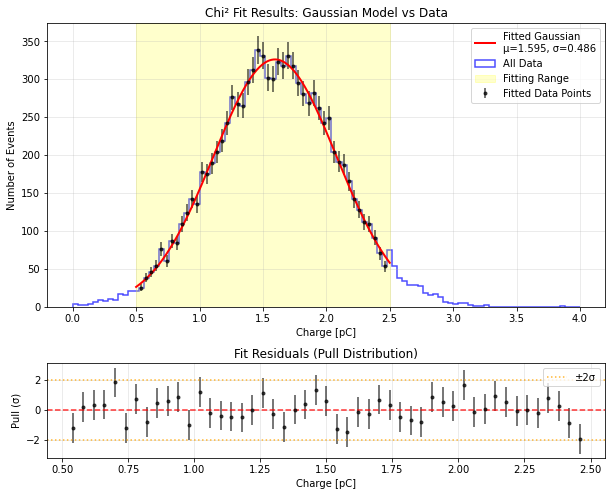

In [13]:
# Create comprehensive visualization of fit results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), 
                               gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.3})

# Top panel: Data and fit
ax1.hist(s, bins=100, range=(0,4), histtype='step', color='blue', 
         label='All Data', alpha=0.7, linewidth=1.5)

# Highlight the fitting region
ax1.axvspan(xmin, xmax, alpha=0.2, color='yellow', label='Fitting Range')

# Plot the fitted function
x_smooth = np.linspace(xmin, xmax, 400)
y_fit = gaus(x_smooth, popt[0], popt[1], popt[2])
ax1.plot(x_smooth, y_fit, 'r-', linewidth=2, 
         label=f'Fitted Gaussian\nμ={popt[1]:.3f}, σ={popt[2]:.3f}')

# Add error bars to data points used in fitting
ax1.errorbar(xdata_fit, ydata_fit, yerr=sigma_fit, fmt='ko', 
             markersize=3, alpha=0.7, label='Fitted Data Points')

ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Number of Events')
ax1.set_title('Chi² Fit Results: Gaussian Model vs Data')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom panel: Residuals
residuals = ydata_fit - gaus(xdata_fit, popt[0], popt[1], popt[2])
pull = residuals / sigma_fit  # Normalized residuals (pulls)

ax2.errorbar(xdata_fit, pull, yerr=1, fmt='ko', markersize=3, alpha=0.7)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.8)
ax2.axhline(y=2, color='orange', linestyle=':', alpha=0.8, label='±2σ')
ax2.axhline(y=-2, color='orange', linestyle=':', alpha=0.8)
ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Pull (σ)')
ax2.set_title('Fit Residuals (Pull Distribution)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Calculate some statistics on the residuals
pull_mean = np.mean(pull)
pull_std = np.std(pull)
print(f"Residual statistics:")
print(f"  Mean of pulls: {pull_mean:.3f} (should be ~0)")
print(f"  Std of pulls: {pull_std:.3f} (should be ~1)")
print(f"  Points outside ±2σ: {np.sum(np.abs(pull) > 2)}/{len(pull)} ({100*np.sum(np.abs(pull) > 2)/len(pull):.1f}%)")

plt.tight_layout()
plt.show()

## Step 6: Calculate Chi² and Goodness-of-Fit

### Understanding Chi² Statistics

The chi-squared statistic quantifies how well our model describes the data:

$$\chi^2 = \sum_{i=1}^{N} \frac{(y_i - f(x_i))^2}{\sigma_i^2}$$

### Reduced Chi² (χ²/ndf)

The **reduced chi-squared** normalizes by the number of degrees of freedom:

$$\chi^2_{\text{red}} = \frac{\chi^2}{\text{ndf}} = \frac{\chi^2}{N - p}$$

Where:
- **N** = number of data points
- **p** = number of fitted parameters
- **ndf** = degrees of freedom = N - p

### Interpreting χ² Values:
- **χ²/ndf ≈ 1**: Good fit (model describes data well within uncertainties)
- **χ²/ndf >> 1**: Poor fit (model doesn't describe data, or uncertainties underestimated)
- **χ²/ndf << 1**: Over-fitting or overestimated uncertainties

### In HEP Context:
- Used to compare different theoretical models
- Assess systematic uncertainties
- Determine parameter constraints and confidence intervals


In [14]:
def calc_chi2(func, popt, xdata, ydata, sigma):
    """
    Calculate chi-squared statistic
    
    Parameters:
    func : function, the model function
    popt : array, optimized parameters
    xdata, ydata : arrays, data points
    sigma : array, uncertainties on ydata
    
    Returns:
    float, chi-squared value
    """
    ymodel = func(xdata, popt[0], popt[1], popt[2])  # Model predictions
    residuals = ydata - ymodel  # Difference between data and model
    chi2_terms = np.square(residuals / sigma)  # Individual chi² contributions
    return np.sum(chi2_terms)  # Total chi²

def calc_reduced_chi2(func, popt, xdata, ydata, sigma):
    """
    Calculate reduced chi-squared (chi²/ndf)
    
    Returns:
    float, reduced chi-squared value
    """
    npar = len(popt)  # Number of free parameters
    ndf = len(xdata) - npar  # Degrees of freedom
    chi2 = calc_chi2(func, popt, xdata, ydata, sigma)
    return chi2 / ndf

# Calculate chi² statistics using the fitted data
chi2_value = calc_chi2(gaus, popt, xdata_fit, ydata_fit, sigma_fit)
reduced_chi2 = calc_reduced_chi2(gaus, popt, xdata_fit, ydata_fit, sigma_fit)
ndf = len(xdata_fit) - len(popt)

print('=== CHI-SQUARED STATISTICS ===')
print(f'Chi² = {chi2_value:.2f}')
print(f'Number of degrees of freedom (ndf) = {ndf}')
print(f'Reduced chi² (χ²/ndf) = {reduced_chi2:.3f}')

# Interpret the results
print('\n=== INTERPRETATION ===')
if 0.8 <= reduced_chi2 <= 1.2:
    print('✓ GOOD FIT: Reduced χ² ≈ 1, model describes data well')
elif reduced_chi2 > 1.2:
    print('⚠ POOR FIT: Reduced χ² > 1, model may not describe data adequately')
    print('  Possible causes: wrong model, underestimated errors, systematic effects')
else:
    print('⚠ SUSPICIOUS: Reduced χ² < 1, may indicate overestimated errors')
    print('  Possible causes: overestimated uncertainties, over-parameterized model')

# Calculate probability that this chi² value could occur by chance
from scipy.stats import chi2 as chi2_dist
p_value = 1 - chi2_dist.cdf(chi2_value, ndf)
print(f'\nP-value = {p_value:.4f}')
print(f'Probability that χ² ≥ {chi2_value:.2f} by chance: {p_value*100:.2f}%')

=== CHI-SQUARED STATISTICS ===
Chi² = 33.41
Number of degrees of freedom (ndf) = 46
Reduced chi² (χ²/ndf) = 0.726

=== INTERPRETATION ===
⚠ SUSPICIOUS: Reduced χ² < 1, may indicate overestimated errors
  Possible causes: overestimated uncertainties, over-parameterized model

P-value = 0.9169
Probability that χ² ≥ 33.41 by chance: 91.69%


## Step 7: Parameter Uncertainties and Error Analysis

### Covariance Matrix

The **covariance matrix** returned by the fitting algorithm contains crucial information about parameter uncertainties and correlations:

$$\text{Cov}_{ij} = \langle (\theta_i - \langle\theta_i\rangle)(\theta_j - \langle\theta_j\rangle) \rangle$$

- **Diagonal elements**: Variances of individual parameters (σ²)
- **Off-diagonal elements**: Covariances between parameter pairs

### Parameter Errors

The **standard error** of each parameter is:
$$\sigma_{\theta_i} = \sqrt{\text{Cov}_{ii}}$$

### Correlation Coefficients

The correlation between parameters i and j is:
$$\rho_{ij} = \frac{\text{Cov}_{ij}}{\sigma_{\theta_i} \sigma_{\theta_j}}$$

### Physical Significance in HEP:
- **Parameter errors**: Determine the precision of your measurement
- **Correlations**: Important for propagating uncertainties in derived quantities
- **Confidence intervals**: Used to set limits on theoretical parameters


In [15]:
# Extract parameter uncertainties from covariance matrix
param_errors = np.sqrt(np.diag(pcov))  # Standard errors = sqrt(diagonal elements)

print('=== PARAMETER UNCERTAINTIES ===')
param_names = ['A (amplitude)', 'μ (mean)', 'σ (std dev)']
param_units = ['events', 'pC', 'pC']

for i, (name, value, error, unit) in enumerate(zip(param_names, popt, param_errors, param_units)):
    relative_error = (error / value) * 100
    print(f'{name:15s}: {value:8.4f} ± {error:8.4f} {unit:6s} ({relative_error:5.2f}%)')

print('\n=== CORRELATION MATRIX ===')
# Calculate correlation matrix from covariance matrix
correlation_matrix = np.zeros_like(pcov)
for i in range(len(popt)):
    for j in range(len(popt)):
        correlation_matrix[i,j] = pcov[i,j] / (param_errors[i] * param_errors[j])

param_labels = ['A', 'μ', 'σ']
print('     ', end='')
for label in param_labels:
    print(f'{label:8s}', end='')
print()

for i, label in enumerate(param_labels):
    print(f'{label:4s} ', end='')
    for j in range(len(param_labels)):
        print(f'{correlation_matrix[i,j]:8.3f}', end='')
    print()

print('\n=== INTERPRETATION OF CORRELATIONS ===')
# Check for significant correlations
threshold = 0.5
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        corr = correlation_matrix[i,j]
        if abs(corr) > threshold:
            print(f'Strong correlation between {param_labels[i]} and {param_labels[j]}: ρ = {corr:.3f}')
            if abs(corr) > 0.8:
                print('  ⚠ Very high correlation - consider reparameterization or more data')
        
# Physical interpretation
print('\n=== PHYSICAL INTERPRETATION ===')
print(f'Measured charge: μ = {popt[1]:.4f} ± {param_errors[1]:.4f} pC')
print(f'Resolution: σ/μ = {popt[2]/popt[1]:.3f} ({(popt[2]/popt[1])*100:.1f}%)')
print(f'Total events in peak: A×σ×√(2π) ≈ {popt[0]*popt[2]*np.sqrt(2*np.pi):.0f}')

=== PARAMETER UNCERTAINTIES ===
A (amplitude)  : 326.0310 ±   3.7278 events ( 1.14%)
μ (mean)       :   1.5950 ±   0.0049 pC     ( 0.31%)
σ (std dev)    :   0.4864 ±   0.0047 pC     ( 0.96%)

=== CORRELATION MATRIX ===
     A       μ       σ       
A       1.000  -0.066  -0.641
μ      -0.066   1.000   0.161
σ      -0.641   0.161   1.000

=== INTERPRETATION OF CORRELATIONS ===
Strong correlation between A and σ: ρ = -0.641

=== PHYSICAL INTERPRETATION ===
Measured charge: μ = 1.5950 ± 0.0049 pC
Resolution: σ/μ = 0.305 (30.5%)
Total events in peak: A×σ×√(2π) ≈ 398


## Summary and Best Practices

### Key Takeaways for HEP Students

1. **Chi² fitting is fundamental** for parameter extraction in experimental particle physics
2. **Always visualize your fits** - plots reveal problems that statistics might miss
3. **Choose fitting ranges carefully** - avoid low statistics and systematic effects
4. **Understand your uncertainties** - Poisson statistics for counting experiments
5. **Check goodness-of-fit** - χ²/ndf should be ≈ 1 for a good fit
6. **Interpret correlations** - they affect uncertainty propagation in derived quantities

### Common Pitfalls to Avoid

❌ **Don't ignore low-statistics bins** - they can dominate χ² inappropriately  
❌ **Don't over-parameterize** - more parameters aren't always better  
❌ **Don't ignore correlations** - they're crucial for error propagation  
❌ **Don't forget to validate** - check residuals and pull distributions  

### Extensions for Advanced Analysis

- **Background modeling**: Add polynomial or exponential background terms
- **Multiple peaks**: Fit multiple Gaussians for complex spectra  
- **Systematic uncertainties**: Include detector calibration and efficiency corrections
- **Bayesian methods**: Alternative to frequentist χ² approach
- **Profile likelihood**: For setting confidence intervals and limits

### Applications in HEP

- **Mass spectra**: Measure particle masses and widths
- **Cross-section measurements**: Extract interaction probabilities
- **Detector calibration**: Determine energy/time calibrations
- **Background estimation**: Separate signal from background
- **New physics searches**: Compare data to Standard Model predictions


In [ ]:
# Exercise for students: Try modifying these parameters and re-running the analysis
print("=== EXERCISES FOR STUDENTS ===")
print("Try modifying the following and observe the effects:")
print("1. Change the number of events (n_events)")
print("2. Change the detector resolution (resolution)")
print("3. Change the fitting range (xmin, xmax)")
print("4. Add a background component to the model")
print("5. Try fitting data with a different underlying distribution")

print("\n=== REFLECTION QUESTIONS ===")
print("- What happens to parameter uncertainties as you increase/decrease statistics?")
print("- How does changing the fitting range affect the results?")
print("- When might you need to include additional parameters in your model?")
print("- How would you handle systematic uncertainties in a real experiment?")
